In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
sys.path.append('/data/des81.b/data/tavangar/streams/model_code')
sys.path.append('/data/des81.b/data/tavangar/streams')
import glob

import numpy as np
import healpy as hp
import fitsio as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
from utils import load_infiles
import pandas as pd

import ugali
from ugali import isochrone

import skymap, skymap.survey
from skymap.utils import cel2gal, gal2cel
from skymap.utils import setdefaults

from streamlib import skymap_factory
import streamlib
import results
import rotation_matrix
import plot_hess
import filter_data

import polyfit2d
from numpy.polynomial import polynomial

import importlib
import imp

import region_plot

/data/des81.b/data/tavangar/streams/code/streamlib.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/traitlets/config/application.py", line 658, i

In [2]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [3]:
sfd = hp.read_map('lambda_sfd_ebv.fits')
nside = hp.get_nside(sfd)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
sfd = sfd[galpix]

#planck = fitsio.read('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')['I_ML_FULL']
planck = hp.read_map('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')
nside = hp.get_nside(planck)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
planck = planck[galpix]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/s1/tavangar/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
p2 = np.load('phoenix_track.npy')
p2

array([-0.10518882, -0.09353363, -0.02134758,  0.06627531,  0.07308069,
       -0.04905011, -0.00637627, -0.03231969,  0.04774872, -0.07668965,
        0.09453083, -0.07064417,  0.04310879,  0.09517855])

## Plotting Functions

In [28]:
def stream_hess(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)) # on stream region
    onstream = data[on]
    #np.save('cmd_fit/phoenix_onstream.npy', onstream)
    print(len(onstream))

    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width))
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    #np.save('cmd_fit/phoenix_offstream.npy', offstream1)
    offstream2 = data[off2]
    #plt.scatter(onstream['SOF_PSF_MAG_CORRECTED_G']-onstream['SOF_PSF_MAG_CORRECTED_R'], 
    #            onstream['SOF_PSF_MAG_CORRECTED_G'], s = 0.01, c = 'b')
    #plt.scatter(offstream1['SOF_PSF_MAG_CORRECTED_G']-offstream1['SOF_PSF_MAG_CORRECTED_R'], 
    #            offstream1['SOF_PSF_MAG_CORRECTED_G'], s = 0.01, c = 'r')
    #plt.ylim(24, 16)
    #plt.xlim(0,1)
    #plt.scatter(phi1[on], phi2[on], s = 0.001)
    #plt.scatter(rrl['ra'], rrl['dec'], s = 5, c='r')
    
    age = 12.8
    metal = 0.00004
    mu = 16.2
    
    age2 = 12.8
    metal2 = 0.00004
    mu2 = 16.2
    
    mk = filter_data.mkpol(mu=mu, age=age, z=metal, dmu=0.5, C=[-0.01, 0.1], E=3., err=None, survey='DES_Y6')
    mk2 = filter_data.mkpol(mu=mu2, age=age2, z=metal2, dmu=0.5, C=[-0.01, 0.1], E=3., err=None, survey='DES_Y6')
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1, dx=0.2 / 5., dy=1 / 6., vmax=12)
    plot_iso(iso, 'r')
    plot_iso(iso2, 'b')
    #plt.plot(mk[:,0], mk[:,1], c='k')
    #plt.plot(mk2[:,0], mk2[:,1], c='b')
    fig.colorbar(im1, ax = ax1)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Above Background Subtracted \n for phi1 = [{},{}]'.format(phi1min, phi1max))

    ax2, im2 = plot_hess.plot_hess(onstream, offstream2, ax=ax2, dx=0.2 / 5., dy=1 / 6.)
    plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1], c='k')
    fig.colorbar(im2, ax = ax2)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Below Background Subtracted \n for phi1 = [{},{}]'.format(phi1min, phi1max))
    
    return ax2, im2
    
def four_stream_hess(minmax_array):
    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
    for i in range(len(minmax_array)):
        stream_hess(data, phi1, phi2, minmax_array[i][0], minmax_array[i][1], stream_width, bkg_start)
        
def plot_iso(iso, c='k'):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    plt.scatter(iso.data['g']-iso.data['r'],iso.data['g'],marker='o',c=c,s=0.5, label='Dotter 2008')
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)
    
def plot_iso2(iso,c='k'):
    plt.scatter(iso.data['r']-iso.data['z'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=0.5)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%('r','z')); plt.ylabel(iso.band_1)

In [6]:
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DESY6_iso_hpxcube_z0.00005_a12.8_gmax24_gmin3p4_E2_C0p010p1.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DESY6_iso_hpxcube_z0.00005_a12.8_gmax24_gmin3p4_E2_C0p010p1.fits.gz...
Skipping fracdet...


## Data Extraction and Cuts

In [7]:
full_data = np.load('full_data_skim.npy')

#load the des data to create the isochrones
#filenames = glob.glob('/data/des81.b/data/tavangar/skim_y6_gold_1_1/*.fits')
#full_data = load_infiles(filenames,columns=[
#    'RA','DEC','SOF_PSF_MAG_CORRECTED_G','SOF_PSF_MAG_CORRECTED_R','SOF_PSF_MAG_CORRECTED_I',
#    'SOF_PSF_MAG_ERR_G', 'SOF_PSF_MAG_ERR_R','EXT_SOF'],multiproc=8)
#np.save('full_data_skim.npy', full_data)

In [8]:
full_data = full_data[full_data['EXT_SOF'] < 2]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G'] < 24.0)]# & (full_data['SOF_PSF_MAG_CORRECTED_G'] > 20.2)]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] < 1)
          &(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] > 0)]
print(len(full_data))

17688359


## Phoenix

/data/des81.b/data/tavangar/streams/code/polyfit2d.py:144: RuntimeWarning: invalid value encountered in sqrt
  fit_errors = np.sqrt(np.diag(cov_mat))


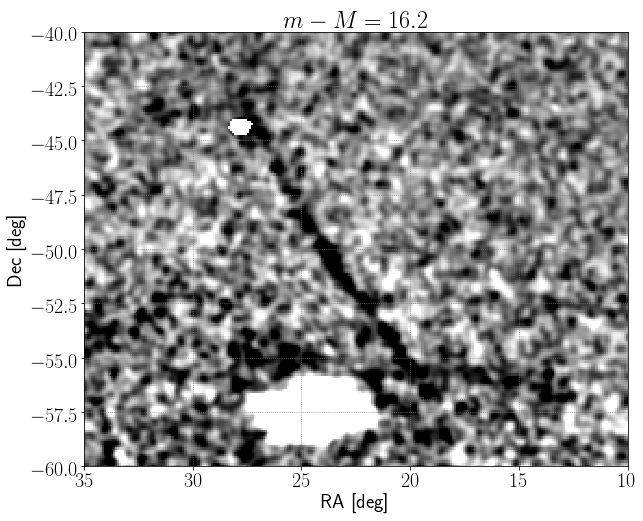

In [9]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(16.2, hpxcube, fracdet, modulus)
xx,yy,smooth = region_plot.run_phoenix(d, dust=sfd, planck=planck, sigma = 0.15)
plt.title(r'$m-M = 16.2$')
plt.xlabel(r'RA [deg]')
plt.ylabel(r'Dec [deg]')
plt.xlim(35,10)
plt.ylim(-60,-40)
plt.savefig('phoenix_spatial.pdf')
plt.show()

/data/des81.b/data/tavangar/streams/code/region_plot.py:541: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p1 = np.linspace(phi1min,phi1max,nphi1pix)
/data/des81.b/data/tavangar/streams/code/region_plot.py:542: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p2 = np.linspace(phi2min,phi2max,nphi2pix)


6.0


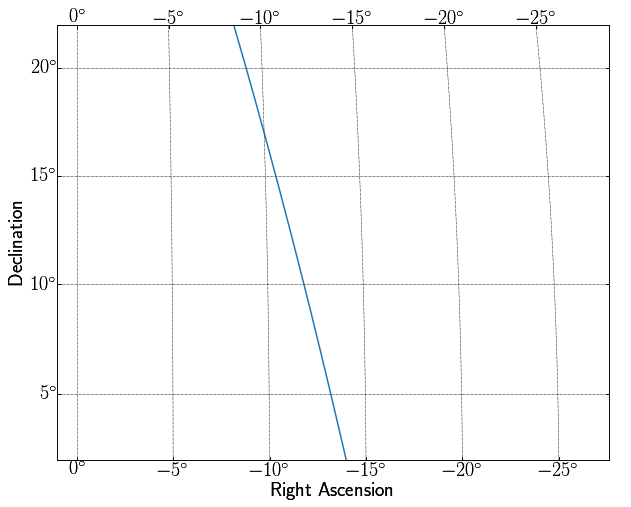

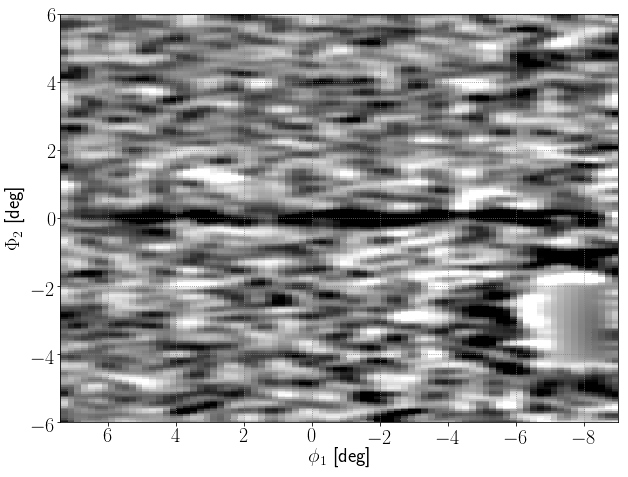

In [10]:
reload(region_plot)
d = region_plot.prepare_hpxmap(16.2, hpxcube, fracdet, modulus)
phoenix_ends = [27.9, -42.7, 20.1, -55.3]   
pp1_0, pp2_0, vv, smooth_res, smooth, vv_mask, vv_res = region_plot.stream_coord_spatial(d, phoenix_ends, full_data, 
                                                                      deg =5, sigma=0.15, stream = 'Phoenix')
#np.save('model_arrays/pp1_full_phoenix_tall.npy', pp1)
#np.save('model_arrays/pp2_full_phoenix_tall.npy', pp2)
#np.save('model_arrays/vv_full_phoenix_tall.npy', vv)
#np.save('model_arrays/smooth_res_full_phoenix_tall.npy', smooth_res)
#np.save('model_arrays/smooth_full_phoenix_tall.npy', smooth)
plt.xlim(7.4, -9)
plt.xlabel(r'$\phi_1$ [deg]')
plt.ylabel(r'$\Phi_2$ [deg]')
#np.save('model_arrays/vv_mask_full_phoenix_tall.npy', vv_mask)
#print(vv_mask)
#plt.scatter(nodes, np.zeros(21),s = 3)
#plt.ylim(-2,2)
plt.show()

In [11]:
#phoenix stream
hh = np.load('phoenix_data_catalogs/phoenix_stream_coord_catalog_paper.npy')
hh = np.transpose(hh)
pp1 = np.load('model_arrays/pp1_full_phoenix_tall.npy')
pp1 = pp1[:,1:-1]
pp2 = np.load('model_arrays/pp2_full_phoenix_tall.npy') 
pp2 = pp2[:,1:-1]
hh[np.where((hh==0) & (pp1<-6))] = np.nan
hh[np.where(hh>16)] = np.nan
hh = hh.astype('int')
vv_mask=hh
mask = hh > -1

phoenix_ends = [27.9, -42.7, 20.1, -55.3]  

smooth_full = np.load('model_arrays/smooth_full_phoenix_tall.npy')[:,1:-1]

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [12]:
data = np.copy(full_data)
phi1, phi2,R = streamlib.rotation(phoenix_ends, data['RA'], data['DEC'])
#print(R)
#np.save('phoenix_rotation_mat.npy', R)

iso = isochrone.factory(name='Dotter2008',
                        age=12.8,  # Gyr
                        metallicity=0.00004, # Z
                        distance_modulus=16.2)

iso2 = isochrone.factory(name='Padova',
                        age=12.8,  # Gyr
                        metallicity=0.00004, # Z
                        distance_modulus=16.2)

print(iso.filename)
print(iso2.filename)

/home/s1/kadrlica/.ugali/isochrones/des/dotter2008/iso_a12.8_z0.00007.dat
/home/s1/kadrlica/.ugali/isochrones/des/marigo2017/iso_a12.8_z0.00010.dat


In [13]:
ends_ra = np.array([27.9, 20.1])
ends_dec = np.array([-42.7, -55.3])
phi11, phi21,R1 = streamlib.rotation(phoenix_ends, ends_ra, ends_dec)
print(phi11, phi21)

(array([ 6.78964646, -6.78964646]), array([6.72464202e-15, 8.87955274e-15]))


9742
Using DES err!
Using DES err!


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc042db81d0>,
 <matplotlib.image.AxesImage at 0x7fc04008dbd0>)

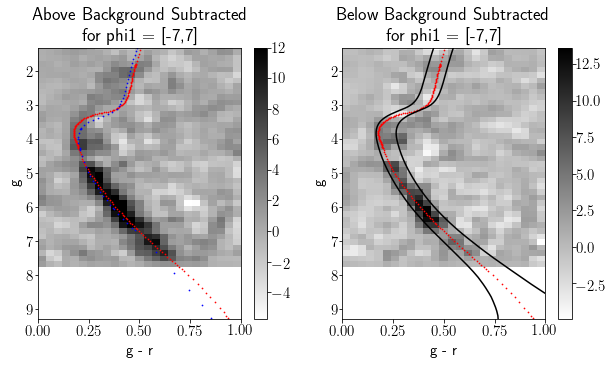

In [29]:
reload(plot_hess)
plot_pretty(fontsize=15)
stream_width = 0.15
bkg_start = 1.
stream_hess(data, phi1, phi2, -7, 7, stream_width, bkg_start)

#four_stream_hess([[-8,-5], [-5,-1], [-1,3], [3,7]])

In [23]:
def hess(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)) # on stream region
    onstream = data[on]
    print(len(onstream))

    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width))
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    offstream2 = data[off2]
    #plt.scatter(onstream['SOF_PSF_MAG_CORRECTED_G']-onstream['SOF_PSF_MAG_CORRECTED_R'], 
    #            onstream['SOF_PSF_MAG_CORRECTED_G'], s = 0.01, c = 'b')
    #plt.scatter(offstream1['SOF_PSF_MAG_CORRECTED_G']-offstream1['SOF_PSF_MAG_CORRECTED_R'], 
    #            offstream1['SOF_PSF_MAG_CORRECTED_G'], s = 0.01, c = 'r')
    #plt.ylim(24, 16)
    #plt.xlim(0,1)
    #plt.scatter(phi1[on], phi2[on], s = 0.001)
    #plt.scatter(rrl['ra'], rrl['dec'], s = 5, c='r')
    
    age = 12.8
    metal = 0.00004
    mu = 16.2
    
    mk = filter_data.mkpol(mu=mu, age=age, z=metal, dmu=0.5, C=[0.01, 0.1], E=2., err=None, survey='DES_Y6')
    fil = np.where((mk[:,1] < 7.6) & (mk[:,1] > 3.4))
    #print(fil)
    
    fig, (ax1) = plt.subplots(1,1, figsize=(6,8))
    ax2 = ax1.twinx()
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1, dx=0.2 / 5., dy=1 / 6., vmax=9)
    print(iso)
    plot_iso(iso, 'b')
    #plot_iso(iso2, 'b')
    ax1.plot(mk[80:198,0], mk[80:198,1], c='r')
    ax1.plot(mk[703:823,0], mk[703:823,1], c='r')
    ax1.plot([mk[703,0], mk[198,0]], [3.4,3.4], c = 'r')
    #ax1.plot([mk[819,0], mk[82,0]], [7.6,7.6], c = 'r')
    #fig.colorbar(im1, ax = ax1)
    ax1.set_xlim(0,1)
    ax1.set_ylim(23.9-mu, 16-mu)
    ax2.set_ylim(23.9, 16)
    ax1.set_ylabel(r'$M_g$')
    ax2.set_ylabel(r'$g$')
    ax1.set_xlabel(r'$g-r$')
    #plt.title(r'Hess Difference')
    plt.savefig('phoenix_hess.pdf')
    
    return ax1, im1

11621
Using DES err!
Dotter2008
  Parameters:
    distance_modulus : Parameter(14.7, [10.0, 30.0], False)
    age              : Parameter(12.8, [1.0, 13.5], False)
    metallicity      : Parameter(4e-05, [7e-05, 0.001], False)
  Filename: /home/s1/kadrlica/.ugali/isochrones/des/dotter2008/iso_a12.8_z0.00007.dat


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc04044eb90>,
 <matplotlib.image.AxesImage at 0x7fc0403f5710>)

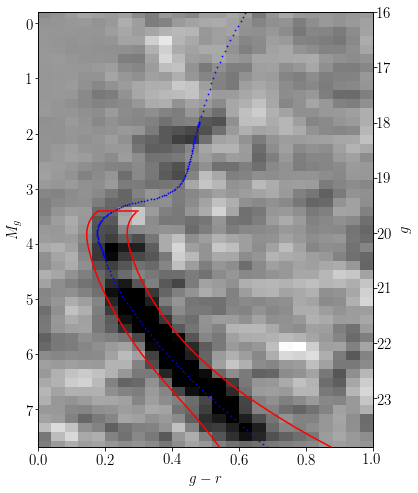

In [27]:
reload(plot_hess)
iso = isochrone.factory(name='Dotter2008',
                        age=12.8,  # Gyr
                        metallicity=0.00004, # Z
                        distance_modulus=14.7)
stream_width = 0.15
hess(data, phi1, phi2, -9, 7.4, stream_width, bkg_start)

# Analysis after Model Completion

#### Load the model

In [5]:
test_load = 7

int1d_map = np.load('model_arrays/phoenix_int1d_map_final_test{}.npy'.format(test_load))
int1d_hi_map = np.load('model_arrays/phoenix_int1d_hi_map_final_test{}.npy'.format(test_load))
int1d_lo_map = np.load('model_arrays/phoenix_int1d_lo_map_final_test{}.npy'.format(test_load))
bkg_map = np.load('model_arrays/phoenix_bkg_map_final_test{}.npy'.format(test_load))
width_map = np.load('model_arrays/phoenix_width_map_final_test{}.npy'.format(test_load))
width_hi_map = np.load('model_arrays/phoenix_width_hi_map_final_test{}.npy'.format(test_load))
width_lo_map = np.load('model_arrays/phoenix_width_lo_map_final_test{}.npy'.format(test_load))
fi2_map = np.load('model_arrays/phoenix_fi2_map_final_test{}.npy'.format(test_load))
fi2_hi_map = np.load('model_arrays/phoenix_fi2_hi_map_final_test{}.npy'.format(test_load))
fi2_lo_map = np.load('model_arrays/phoenix_fi2_lo_map_final_test{}.npy'.format(test_load))

int_map=int1d_map[80] * width_map[80] * np.sqrt(1/(2*np.pi)) * np.e**(-0.5 * ((pp2 - fi2_map[80])/(width_map[80]))**2)

In [6]:
'''
full_mem = pd.read_csv('s5_data_phoenix/phoenix_mem_full.csv')
mem_ra = full_mem['ra']
mem_dec = full_mem['dec']
phi1_mem, phi2_mem, R = streamlib.rotation(phoenix_ends, mem_ra, mem_dec)

highsnr_mem = pd.read_csv('s5_data_phoenix/phoenix_mem_high_snr.csv')
highmem_ra = highsnr_mem['ra']
highmem_dec = highsnr_mem['dec']
phi1_highmem, phi2_highmem, R = streamlib.rotation(phoenix_ends, highmem_ra, highmem_dec)
np.save('s5_data_phoenix/phi1_mem.npy', phi1_mem)
np.save('s5_data_phoenix/phi1_highmem.npy', phi1_highmem)
np.save('s5_data_phoenix/phi2_mem.npy', phi2_mem)
np.save('s5_data_phoenix/phi2_highmem.npy', phi2_highmem)
'''

"\nfull_mem = pd.read_csv('s5_data_phoenix/phoenix_mem_full.csv')\nmem_ra = full_mem['ra']\nmem_dec = full_mem['dec']\nphi1_mem, phi2_mem, R = streamlib.rotation(phoenix_ends, mem_ra, mem_dec)\n\nhighsnr_mem = pd.read_csv('s5_data_phoenix/phoenix_mem_high_snr.csv')\nhighmem_ra = highsnr_mem['ra']\nhighmem_dec = highsnr_mem['dec']\nphi1_highmem, phi2_highmem, R = streamlib.rotation(phoenix_ends, highmem_ra, highmem_dec)\nnp.save('s5_data_phoenix/phi1_mem.npy', phi1_mem)\nnp.save('s5_data_phoenix/phi1_highmem.npy', phi1_highmem)\nnp.save('s5_data_phoenix/phi2_mem.npy', phi2_mem)\nnp.save('s5_data_phoenix/phi2_highmem.npy', phi2_highmem)\n"

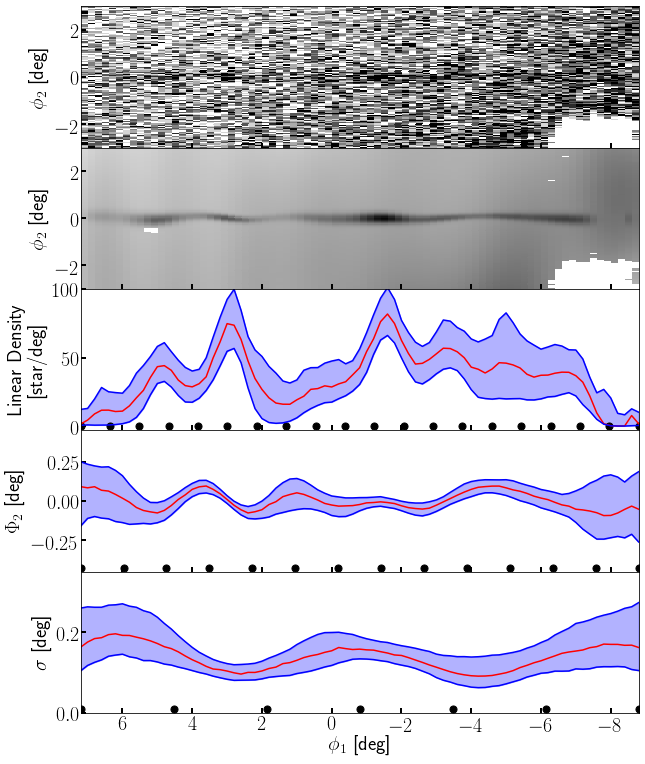

In [11]:
# plot for the paper

fig, axs = plt.subplots(5,1, figsize=(10,13), sharex=True)

axs[0].tick_params(axis='both', which='both', direction = 'in', width=2, length=5)
axs[1].tick_params(axis='both', which='both', direction = 'in', width=2, length=5)
axs[2].tick_params(axis='both', which='both', direction = 'in', width=2, length=5)
axs[3].tick_params(axis='both', which='both', direction = 'in', width=2, length=5)
axs[4].tick_params(axis='both', which='both', direction = 'in', width=2, length=5)

axs[0].pcolormesh(pp1, pp2, hh, vmin = 2, vmax = 8, cmap='gray_r', rasterized = True)
axs[0].set_xlim(7.2, -8.8)
axs[0].set_ylim(-3, 3)
axs[0].set_ylabel(r'$\phi_2$ [deg]')
for tick in axs[0].get_xticklabels():
    tick.set_visible(True)


axs[1].pcolormesh(pp1, pp2, int_map+bkg_map, vmin = 2, vmax = 10, cmap='gray_r', rasterized=True)
axs[1].set_ylim(-3, 3)
axs[1].set_xlim(7.2, -8.8)
axs[1].set_ylabel(r'$\phi_2$ [deg]')
for tick in axs[1].get_xticklabels():
    tick.set_visible(True)


axs[2].plot(pp1[80], int1d_map[80], c = 'r')
axs[2].plot(pp1[80], int1d_hi_map[80], c = 'b')
axs[2].plot(pp1[0], int1d_lo_map[80], c = 'b')
axs[2].fill_between(pp1[80], int1d_lo_map[80], int1d_hi_map[80], alpha = 0.3, color= 'b')
axs[2].set_ylim(-3, 100)
axs[2].set_ylabel('Linear Density \n [star/deg]')
axs[2].scatter(np.linspace(-8.8,7.2,20), np.zeros(20), c = 'k', s = 50, label = 'nodes')
for tick in axs[2].get_xticklabels():
    tick.set_visible(True)

axs[3].plot(pp1[80], fi2_map[80], c = 'r')
axs[3].plot(pp1[80], fi2_hi_map[80], c = 'b')
axs[3].plot(pp1[80], fi2_lo_map[80], c = 'b')
axs[3].fill_between(pp1[80], fi2_lo_map[80], fi2_hi_map[80], alpha = 0.3, color= 'b')
axs[3].set_ylim(-0.45, 0.45)
axs[3].set_ylabel(r'$\Phi_2$ [deg]')
axs[3].scatter(np.linspace(-8.8,7.2,14), np.zeros(14)-0.425,c = 'k', s = 50, label = 'nodes')
for tick in axs[3].get_xticklabels():
    tick.set_visible(True)


axs[4].plot(pp1[80], width_map[80], c = 'r')
axs[4].plot(pp1[80], width_hi_map[80], c = 'b')
axs[4].plot(pp1[80], width_lo_map[80], c = 'b')
axs[4].fill_between(pp1[80], width_lo_map[80], width_hi_map[80], alpha = 0.3, color= 'b')
axs[4].set_ylim(0, 0.35)
axs[4].set_ylabel(r'$\sigma$ [deg]')
axs[4].set_xlabel(r'$\phi_1$ [deg]')
axs[4].scatter(np.linspace(-8.8,7.2,7), np.zeros(7)+0.01,c = 'k', s = 50, label = 'nodes')
for tick in axs[4].get_xticklabels():
    tick.set_visible(True)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('model_results.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
print(int1d_map[80][-7], int1d_map[80][-17], int1d_map[-80][-13])
(2*int1d_map[-80][-13]) / (1.2*int1d_map[80][-7] + 0.8*int1d_map[80][-17])

(10.931591820496065, 28.60727875740155, 44.074484215045345)


2.4483285653641436

In [22]:
print(int1d_map[80][-22], int1d_map[80][-17], int1d_map[-80][-30])
(2.6*int1d_map[-80][-22]) / (1*int1d_map[80][-7] + 1.6*int1d_map[80][-30])

(74.68152829202619, 28.60727875740155, 15.971482658827073)


5.32182658411209

In [23]:
print(pp1[80][-41], pp1[80][-45], pp1[-80][-49])
print(int1d_map[80][-41], int1d_map[80][-45], int1d_map[-80][-49])
(1.6*int1d_map[-80][-45]) / (0.8*int1d_map[80][-41] + 0.8*int1d_map[80][-49])

(-0.8000000000000007, -1.6000000000000005, -2.4000000000000004)
(42.54104827170397, 81.6912227119141, 45.24168237173246)


1.861213979404096


#### Defining the Stream Track

Text(0.5,1,'Stream Track and Width')

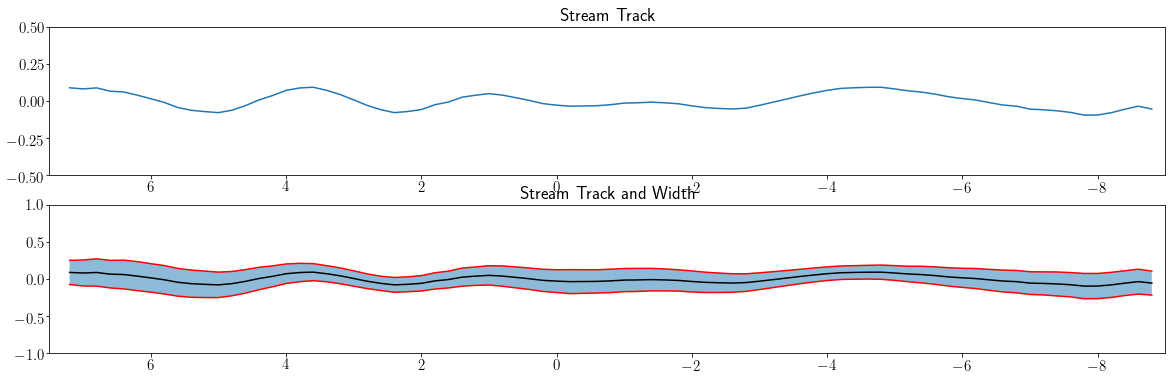

In [24]:
fig, axs = plt.subplots(2,1, figsize=(20,6))

axs[0].plot(pp1[80], fi2_map[80])
axs[0].set_xlim(7.5, -9)
axs[0].set_ylim(-0.5,0.5)
axs[0].set_title('Stream Track')

axs[1].plot(pp1[80], fi2_map[80], c = 'k')
axs[1].plot(pp1[80], fi2_map[80] + width_map[80], c = 'r')
axs[1].plot(pp1[80], fi2_map[80] - width_map[80], c = 'r')
axs[1].fill_between(pp1[80], fi2_map[80] - width_map[80], fi2_map[80] + width_map[80], alpha=0.5)
axs[1].set_xlim(7.5, -9)
axs[1].set_ylim(-1, 1)
axs[1].set_title('Stream Track and Width')

In [25]:
np.mean(width_map[80]), np.mean(width_hi_map[80]), np.mean(width_lo_map[80])

(0.1390575157778485, 0.1868348329276148, 0.1043562325333394)

#### Making Hess Plots with the new Stream Track region

In [26]:
upper_track = fi2_map[80] + width_map[80]
lower_track = fi2_map[80] - width_map[80]

def stream_hess_adv(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    #preliminary cut to reduce for loop
    select1 = np.where((phi1<phi1max) & (phi1>phi1min) & 
                       (phi2 < np.max(upper_track)) & (phi2 > np.min(lower_track)))# on stream region
    round_phi1 = np.around(phi1*5) /5
    phi1s = np.around(pp1[80], 1)
    select = []
    for i in select1[0]:
        ind = np.where(phi1s == round_phi1[i])
        up, down = upper_track[ind], lower_track[ind]
        if (phi2[i] < up) & (phi2[i] > down):
            select = np.append(select, i)
    
    select = select.astype('int')
    onstream = data[select]
    
    
    # off stream region calculation    
    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width))
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    offstream2 = data[off2]
    #plt.scatter(onstream['SOF_PSF_MAG_CORRECTED_G']-onstream['SOF_PSF_MAG_CORRECTED_R'], 
    #            onstream['SOF_PSF_MAG_CORRECTED_G'], s = 0.01, c = 'b')
    #plt.scatter(offstream1['SOF_PSF_MAG_CORRECTED_G']-offstream1['SOF_PSF_MAG_CORRECTED_R'], 
    #            offstream1['SOF_PSF_MAG_CORRECTED_G'], s = 0.008, c = 'r')
    #plt.ylim(24, 16)
    #plt.xlim(0,1)
    
    #area correction
    onpix = hp.ang2pix(256, onstream['RA'], onstream['DEC'], lonlat=True)
    onpix = np.unique(onpix)
    print('number of hpxcube in stream: {}'.format(len(onpix)))

    offpix1 = hp.ang2pix(256, offstream1['RA'], offstream1['DEC'], lonlat=True)
    offpix1 = np.unique(offpix1)
    print('number of hpxcube in above background: {}'.format(len(offpix1)))

    offpix2 = hp.ang2pix(256, offstream2['RA'], offstream2['DEC'], lonlat=True)
    offpix2 = np.unique(offpix2)
    print('number of hpxcube in below background: {}'.format(len(offpix2)))
    
    offstream = (len(offpix1)+len(offpix2))/2.
    print(offstream)
    scale_factor1 = np.float(len(offpix1))/np.float(len(onpix))
    scale_factor2 = np.float(len(offpix2))/np.float(len(onpix))
    print(scale_factor1, scale_factor2)
    sig1 = (len(onstream) * scale_factor1 - len(offstream1))/np.sqrt(len(offstream1))
    sig2 = (len(onstream) * scale_factor2 - len(offstream2))/np.sqrt(len(offstream2))
    
    
    # plot the results
    plt.figure(figsize = (20, 4))
    plt.scatter(phi1[select], phi2[select], s = 0.01)
    plt.plot(pp1[80], fi2_map[80], c = 'k')
    plt.plot(pp1[80], fi2_map[80] + width_map[80], c = 'r')
    plt.plot(pp1[80], fi2_map[80] - width_map[80], c = 'r')
    plt.xlim(7.5, -9)
    plt.ylim(-0.6, 0.6)
    
    age = 12.8
    metal = 0.00005
    mu = 16.2
    mk = filter_data.mkpol(mu=mu, age=age, z=metal, dmu=0.05, C=[0.01, 0.1], E=2., err=None, survey='DES_Y6')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    dx_highres, dy_highres = 0.1/5., 0.5/6.
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1, dx=dx_highres, dy=dy_highres, vmax=5)
    #plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1], c='k')
    fig.colorbar(im1, ax = ax1)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Residual'.format(phi1min, phi1max))

    ax2, im2 = plot_hess.plot_hess(onstream, ax=ax2, dx=dx_highres, dy=dy_highres, no_bkg=True, vmax=10)
    plot_iso(iso, 'r')
    #plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im2, ax = ax2)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Data Onstream'.format(phi1min, phi1max))
    
    '''
    ax3, im3 = plot_hess.plot_hess(offstream1, ax=ax3, dx=dx_highres, dy=dy_highres)
    plot_iso(iso, 'r')
    #plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im3, ax = ax3)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Data Offstream Above'.format(phi1min, phi1max))
    
    ax4, im4 = plot_hess.plot_hess(offstream2, ax=ax4, dx=dx_highres, dy=dy_highres)
    plot_iso(iso, 'r')
    #plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im4, ax = ax4)
    plt.xlim(0,1)
    plt.ylim(24-mu, 16-mu)
    plt.title('Data Offstream Below'.format(phi1min, phi1max))
    '''
    return sig1, sig2, onstream

number of hpxcube in stream: 134
number of hpxcube in above background: 137
number of hpxcube in below background: 135
136.0
(1.0223880597014925, 1.007462686567164)
Using DES err!


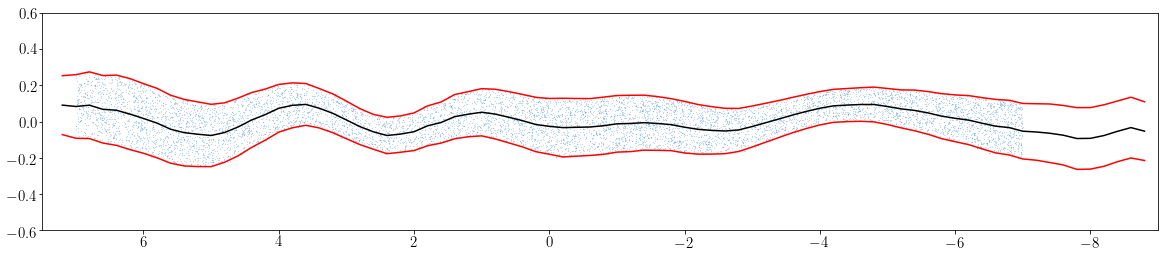

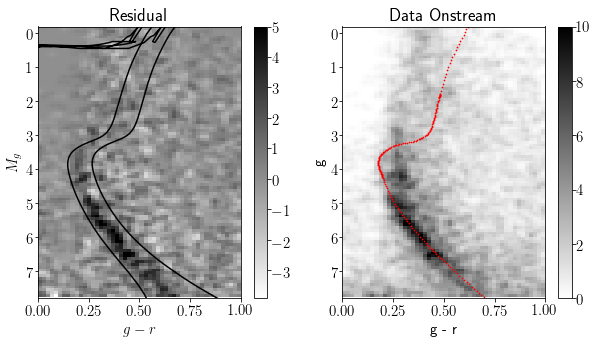

significance subtracting above = 7.00439155098
significance subtracting below = 0.496009875551


In [27]:
data = np.copy(full_data)
phi1, phi2,R = streamlib.rotation(phoenix_ends, data['RA'], data['DEC'])

iso = isochrone.factory(name='Dotter2008',
                        age=12.8,  # Gyr
                        metallicity=0.00004, # Z
                        distance_modulus=16.2)

stream_width = np.median(width_map[80])
bkg_start = 1
sig1, sig2, onstream = stream_hess_adv(data, phi1, phi2, -7, 7, stream_width, bkg_start)
plt.show()
print('significance subtracting above = {}'.format(sig1))
print('significance subtracting below = {}'.format(sig2))

## Distance Modulus Calculation

In [28]:
import filter_data
E=2
C=[0.01,0.1]
gmin=19.6
survey='DES_Y6'

angsep = ugali.utils.projector.angsep(27.77642, -44.44469, onstream['RA'], onstream['DEC'])

below_msto = onstream[(onstream['SOF_PSF_MAG_CORRECTED_G'] > gmin) & 
                     (onstream['SOF_PSF_MAG_CORRECTED_G']-onstream['SOF_PSF_MAG_CORRECTED_R'] > 0) &
                     (onstream['SOF_PSF_MAG_CORRECTED_G']-onstream['SOF_PSF_MAG_CORRECTED_R'] < 1) &
                     (onstream['SOF_PSF_MAG_CORRECTED_G'] < 24.0) & (angsep>0.3)]

# need to add a mask for the phoenix 
dist_mod_range = 176
dist_array = np.linspace(14.5, 18, dist_mod_range)

ra_cut = below_msto['RA']
dec_cut = below_msto['DEC']
phi1, phi2, R = streamlib.rotation(phoenix_ends, ra_cut, dec_cut)

phi1s = []
moduli = []
for i in dist_array:
    sel = filter_data.select_isochrone(below_msto['SOF_PSF_MAG_CORRECTED_G'], below_msto['SOF_PSF_MAG_CORRECTED_R'], 
                                    err=None, iso_params=[i, 12.8, 0.00004], C=C, E=E, gmin=gmin, survey=survey)
    cut = np.where(sel)[0]
    add2mod = np.zeros(len(cut)) + i
    for j in cut:
        phi1s = np.append(phi1s, phi1[j])
    moduli = np.concatenate((moduli, add2mod))

Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES err!
Using DES 

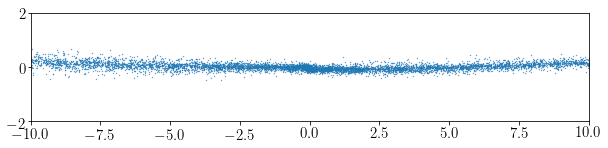

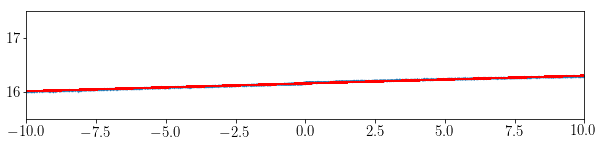

In [29]:
orbitm = pd.read_csv('Phoenix_335_model.txt', sep=' ')
plt.figure(figsize=(10,2))
plt.scatter(orbitm['phi1'], orbitm['phi2'], s=0.1)
plt.xlim(-10,10)
plt.ylim(-2,2)

plt.figure(figsize=(10,2))
plt.scatter(orbitm['phi1'], 5*np.log10(1000*orbitm['d']) - 5, s=0.1)
plt.xlim(-10,10)
plt.ylim(15.5,17.5)

from sklearn.linear_model import LinearRegression
orbit_phi1 = orbitm['phi1'].reshape((-1, 1))
model = LinearRegression().fit(orbit_phi1, 5*np.log10(1000*orbitm['d']) - 5)
model1 = LinearRegression().fit(orbit_phi1, orbitm['d'])

orbit_dist_pred = model.predict(orbit_phi1.reshape((-1, 1)))
plt.plot(orbit_phi1, orbit_dist_pred, c='r')

In [30]:
print(model.coef_)
model.predict(0)
print(model1.coef_)

[0.01435024]
[0.11167272]


In [31]:
#phoenix BHBs
brb_phi1, brb_phi2,brb_R=streamlib.rotation(phoenix_ends,
                                            np.array([24.5067, 22.2491, 19.7592]),
                                            np.array([-49.4296, -53.2520, -55.1281]))
brb_dm = 16.2406439748094, 16.316514759566733, 16.318683932253105

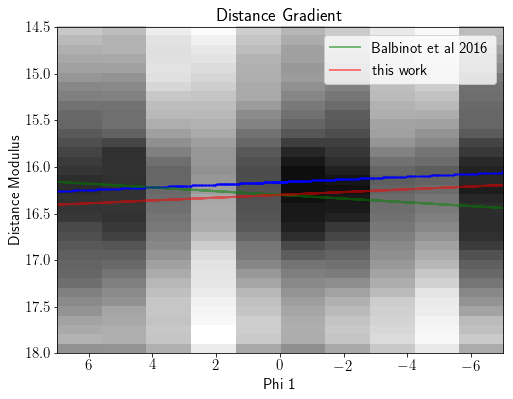

In [32]:
from scipy.stats import norm
plt.figure(figsize = (8,6))
#print(np.min(moduli))
v = plt.hist2d(phi1s, moduli, bins=(10, 35), range=([-7,7], [14.5, 18]), vmax=1500) 
cmap = mpl.cm.gray_r
cmap.set_bad('black',1.)
# stopped at 6 so that that the width isn't a factor and the potential gradient is easier to see
plt.xlim(7, -7)
plt.ylim(18, 14.5)
ys1 = -0.02*phi1+16.3
ys3 = 0.015*phi1+16.3
plt.xlabel(r'Phi 1')
plt.ylabel(r'Distance Modulus')
plt.plot(phi1, ys1, linewidth = 2, c = 'g', alpha = 0.5, label=r'Balbinot et al 2016')
plt.plot(phi1, ys3, linewidth = 2, c = 'r', alpha=0.5, label=r'this work')
plt.scatter(orbit_phi1, orbit_dist_pred, s=0.1, c='b')
plt.title(r'Distance Gradient')
plt.legend()
plt.show()

fhistmap = np.transpose(np.array(v[0]))

#print(np.min(fhistmap))
backg = np.mean(np.append(fhistmap[:10], fhistmap[-10:]))
peak_ave = np.mean(fhistmap[15:20])

from astropy.modeling import models, fitting
allsigma, allmeans = [], []
for i in range(10):
    #print(v[0][i])
    #v[0][i] = v[0][i] * 0.2 / width_map[80][5*i+12]
    v[0][i] = v[0][i] * 0.2 / width_map[80][7*i+13]
    
    datafit = []
    for j in range(35):
        datafit = np.append(datafit, np.repeat(v[2][j],v[0][i][j]))
    
    bin_heights, bin_borders = np.histogram(datafit, bins=34)
    bin_widths = np.diff(bin_borders)[0]
    bin_centers_dist = bin_borders + bin_widths/2
    bin_centers_dist = bin_centers_dist[:-1]

    t_init = models.Gaussian1D(amplitude= 1000., mean=16.3)
    fit_t = fitting.LevMarLSQFitter()
    
    t = fit_t(t_init, bin_centers_dist[12:-10], bin_heights[12:-10] - backg)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    #plt.figure()
    #plt.bar(bin_centers_dist, bin_heights, width=bin_widths, label='histogram')
    #plt.plot(x_interval_for_fit, t(x_interval_for_fit) + backg, label='fit', c='red')
    #plt.legend()
    
    #plt.show()
    #print(t)
    allmeans = np.append(allmeans, t.mean)
    allsigma = np.append(allsigma, t.stddev)

665.4320292957048


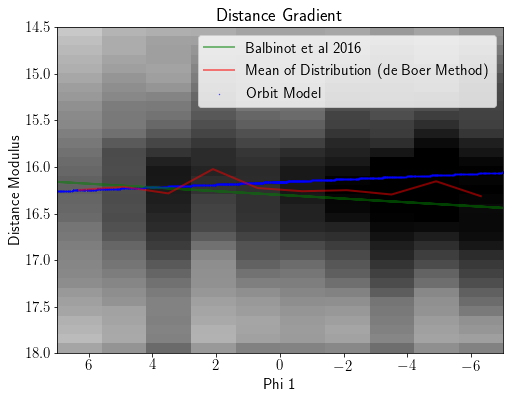

In [33]:
histmap = np.transpose(np.array(v[0]))

print(np.min(histmap))

xs = np.linspace(-7.0, 7, 11)
ys = np.linspace(14.5, 18, 36)
xx,yy = np.meshgrid(xs, ys)
plt.figure(figsize = (8,6))
plt.pcolormesh(xx,yy,histmap, vmin=300, vmax=2000)
plt.plot(phi1, ys1, linewidth = 2, c = 'g', alpha = 0.5, label=r'Balbinot et al 2016')
plt.scatter(orbit_phi1, orbit_dist_pred, s=0.1, c='b', label='Orbit Model')
bin_widths = np.diff(v[1])[0]
bin_centers = v[1][:-1] + bin_widths / 2
plt.plot(bin_centers, allmeans, linewidth = 2, c = 'r', alpha=0.5, label=r'Mean of Distribution (de Boer Method)')
#plt.errorbar(bin_centers, allmeans, yerr=allsigma, xerr=None, 
#             linewidth = 2, c = 'r', alpha=0.5, label=r'Mean of Distribution (de Boer Method)')
plt.xlim(7, -7.0)
plt.ylim(18, 14.5)
plt.xlabel(r'Phi 1')
plt.ylabel(r'Distance Modulus')
plt.title(r'Distance Gradient')
plt.legend()
plt.show()

In [34]:
#creating a model to compare the actual histogram                

x_interval_for_fit = np.linspace(bin_centers_dist[0], bin_centers_dist[-1], len(bin_centers_dist)+1)

[-6.3 -4.9 -3.5 -2.1 -0.7  0.7  2.1  3.5  4.9  6.3]
[2036.05584719 2294.69898546 2143.04229397 2002.01528075 1835.83212991
 1713.6630578  1756.14477642 1845.4111562  1506.44024296 1357.68767528]
(2294.6989854578974, (array([15]), array([1])))


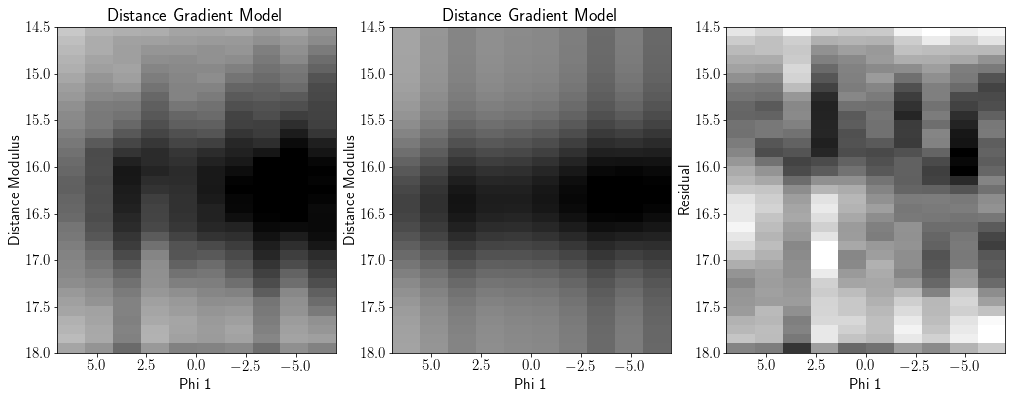

In [35]:
from sklearn.preprocessing import normalize

gradient_model = np.zeros((35,10))

gradient_model3 = np.copy(gradient_model)

grad3 = 0.01*bin_centers+16.3
stddev = 0.5

#def find_nearest(array, value):
#    idx = []
#    for i in range(len(value)):
#        array = np.asarray(array)
#        idx1 = (np.abs(array - value[i])).argmin()
#        idx = np.append(idx, idx1)
#    return idx.astype('int')

lin_int = int1d_map[80]
int_corr = np.zeros(len(bin_centers))

#near_poss = np.zeros((6, len(bin_centers)))
#near_poss[0] = find_nearest(pp1[80], bin_centers)
#near_poss[1] = find_nearest(pp1[80], bin_centers+0.2)
#near_poss[2] = find_nearest(pp1[80], bin_centers+0.4)
#near_poss[3] = find_nearest(pp1[80], bin_centers+0.6)
#near_poss[4] = find_nearest(pp1[80], bin_centers-0.2)
#near_poss[5] = find_nearest(pp1[80], bin_centers-0.4)

#for i in range(len(near_poss[0])):
#    int_corr = np.append(int_corr, np.mean([lin_int[int(near_poss[0,i])], 
#                                            lin_int[int(near_poss[1,i])], 
#                                            lin_int[int(near_poss[2,i])],
#                                            lin_int[int(near_poss[3,i])], 
#                                            lin_int[int(near_poss[4,i])], 
#                                            lin_int[int(near_poss[5,i])]]))
print(bin_centers)
for i in range(len(bin_centers)):    
    int_corr[i] = np.max(histmap[:,i])
print(int_corr)
print(np.max(histmap), np.where(histmap ==np.max(histmap)))

int_corr = int_corr / np.max(int_corr)

background = np.concatenate((histmap[:10], histmap[-10:]))
backg = np.apply_along_axis(np.mean, axis=0, arr = background)

peak_ave = np.max(histmap[15:20])

for i in range(len(grad3)):
    gradient_model3[:,i] = norm.pdf(x_interval_for_fit, grad3[i], stddev)
    gradient_model3[:,i] = gradient_model3[:,i] * int_corr[i]
gradient_model33 = gradient_model3*(peak_ave-backg) + backg

norm_histmap = histmap
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,6))
ax3.pcolormesh(xx,yy,histmap - gradient_model33, vmin=-300, vmax=300)
ax3.set_xlim(7, -7)
ax3.set_ylim(18, 14.5)
ax3.set_xlabel(r'Phi 1')
ax3.set_ylabel(r'Residual')
ax3.set_title(r'')

ax1.pcolormesh(xx,yy,histmap, vmax=2000, vmin=300)
ax1.set_xlim(7, -7)
ax1.set_ylim(18, 14.5)
ax1.set_xlabel(r'Phi 1')
ax1.set_ylabel(r'Distance Modulus')
ax1.set_title(r'Distance Gradient Model')

ax2.pcolormesh(xx,yy,gradient_model33, vmax=2000, vmin=300)
ax2.set_xlim(7, -7)
ax2.set_ylim(18, 14.5)
ax2.set_xlabel(r'Phi 1')
ax2.set_ylabel(r'Distance Modulus')
ax2.set_title(r'Distance Gradient Model')
plt.savefig
plt.show()

In [36]:
from scipy.stats import poisson
def log_prior(model_parameters):
    slope, yint, width = model_parameters
    if (width < 0.2) | (width > 0.7) | (slope > 0.2) | (slope < -0.2) | (yint < 16) | (yint > 16.6):
        return -np.inf
    return 0.0

def log_likelihood(model_parameters, histmap): # model_parameters = [slope, y-int, gaussian width]
    slope, yint, width = model_parameters
    grad_model = np.zeros((35,10))
    
    lin_int = int1d_map[80]
    int_corr = np.zeros(len(bin_centers))

    for i in range(len(bin_centers)):    
        int_corr[i] = np.max(histmap[:,i])

    int_corr = int_corr / np.max(int_corr)

    background = np.concatenate((histmap[:10], histmap[-10:]))
    backg = np.apply_along_axis(np.mean, axis=0, arr = background)

    peak_ave = np.max(norm_histmap[15:20])

    for i in range(len(bin_centers)):
        grad_model[:,i] = norm.pdf(x_interval_for_fit, slope*bin_centers[i]+yint, width)
        grad_model[:,i] = grad_model[:,i] * int_corr[i]
    grad_model = grad_model*(peak_ave-backg) + backg
        
    grad_model= grad_model[10:25]
    norm_hist_lim = histmap[10:25]
    diff = norm_hist_lim - grad_model
    #lik = np.dot(np.ravel(diff), np.ravel(diff))
    loglik = norm.logpdf(norm_hist_lim, grad_model)
    return np.sum(loglik)

def log_probability(model_parameters, norm_histmap):
    lp = log_prior(model_parameters)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp + log_likelihood(model_parameters, norm_histmap))
    return lp + log_likelihood(model_parameters, norm_histmap)

In [37]:
log_probability([-0.004,16.2, 0.51], norm_histmap)
log_probability([-0.001, 16.2, 0.51], norm_histmap)
log_probability([0.002,16.2, 0.51], norm_histmap)

-792173.1143475755

In [38]:
import emcee
import warnings; warnings.simplefilter('ignore')
ndim, nwalkers = 3, int(12)
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
p0[:, 0] = p0[:, 0]*.4 - 0.2  # slope: (-0.2, 0.2) # might want to log space?
p0[:, 1] = p0[:, 1]*0.5 + 16  # distance_modulus: (16.0, 16.5)
p0[:, 2] = p0[:, 2]*0.4 + 0.25  # gaussian width: [0.25, 0.65]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[histmap])

print(p0)
# burn-in
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

pos, prob, state = sampler.run_mcmc(pos, 10000)

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

[[-1.74655730e-01  1.60421183e+01  2.68373852e-01]
 [-6.38706226e-02  1.60856879e+01  5.48442651e-01]
 [-7.08676249e-03  1.60988648e+01  4.77883244e-01]
 [-7.39896739e-02  1.60382683e+01  4.37762535e-01]
 [ 1.25914855e-02  1.63337388e+01  5.47858736e-01]
 [ 1.77175725e-01  1.61473389e+01  3.65412713e-01]
 [-1.14330690e-01  1.64344721e+01  5.39682993e-01]
 [-1.64553564e-01  1.61657584e+01  6.00789548e-01]
 [-9.32347840e-02  1.63076896e+01  5.00596134e-01]
 [-1.59333183e-01  1.63200479e+01  4.55619999e-01]
 [-1.50679448e-01  1.62708027e+01  2.62865067e-01]
 [-1.63109401e-01  1.62647694e+01  3.17601836e-01]]
Mean acceptance fraction: 0.645


In [39]:
print(pos)

[[-1.10943730e-03  1.61902086e+01  5.17906491e-01]
 [-1.07628600e-03  1.61901598e+01  5.17664745e-01]
 [-1.13046830e-03  1.61901287e+01  5.17726645e-01]
 [-1.07731318e-03  1.61900697e+01  5.17943569e-01]
 [-1.09575797e-03  1.61901970e+01  5.17957076e-01]
 [-1.12149884e-03  1.61900577e+01  5.17759016e-01]
 [-1.13901643e-03  1.61899087e+01  5.17723568e-01]
 [-1.22803615e-03  1.61897726e+01  5.17747698e-01]
 [-1.10391873e-03  1.61903028e+01  5.17832109e-01]
 [-1.12905170e-03  1.61900974e+01  5.17631418e-01]
 [-1.15513119e-03  1.61900628e+01  5.17731389e-01]
 [-1.09828689e-03  1.61899933e+01  5.17844033e-01]]


-0.00128115027338506


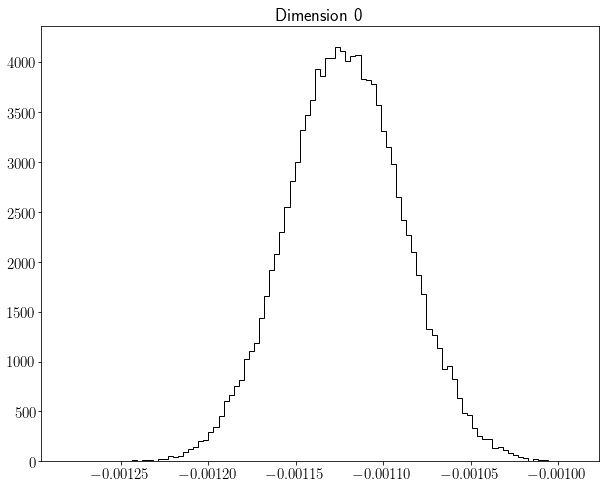

16.189600698390034


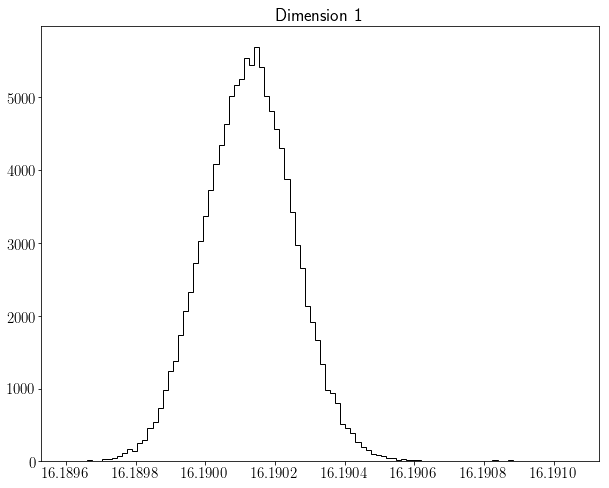

0.5173694813935716


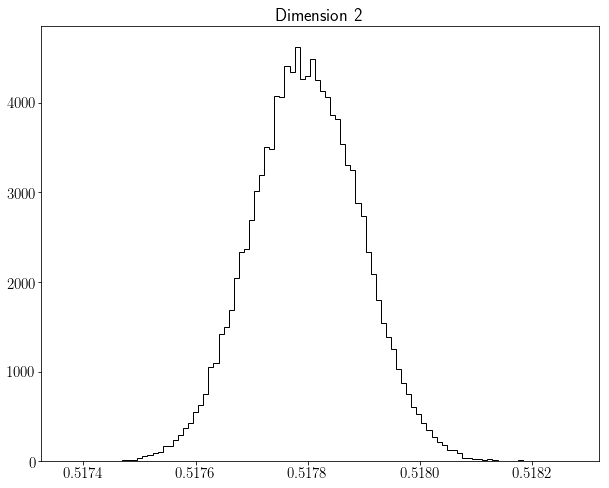

(-0.001121908243331058, 3.327687765033662e-05)
(16.190125676300394, 0.00012840177630197845)
(0.5177970621508466, 9.652815819483436e-05)


In [40]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:, i], 100, color="k", histtype="step")
    print(np.min(sampler.flatchain[:, i]))
    plt.title("Dimension {0:d}".format(i))
    #plt.savefig('likelihood_sgr_%i.png' % i)
    plt.show()

samples = sampler.chain.reshape(-1, ndim)
print(np.mean(sampler.flatchain[:, 0]), np.std(sampler.flatchain[:, 0]))
print(np.mean(sampler.flatchain[:, 1]), np.std(sampler.flatchain[:, 1]))
print(np.mean(sampler.flatchain[:, 2]), np.std(sampler.flatchain[:, 2]))

In [41]:
for i in range(len(bin_centers)):
    samples[:,0]*bin_centers[i]+samples[:,1]


In [42]:
bin_centers

array([-6.3, -4.9, -3.5, -2.1, -0.7,  0.7,  2.1,  3.5,  4.9,  6.3])

In [43]:
a = samples[:,0]*-2.1+samples[:,1]
np.mean(a), np.std(a)

(16.192481683611387, 0.00012646914330404074)

(-0.001121908243331058, 16.190125676300394, 0.5177970621508466)
[1303.25317626 1164.54410366 1286.21787497 1156.22006102 1089.45999021
 1075.4184479  1044.40723721 1109.1545436  1001.87000714  904.72964045]


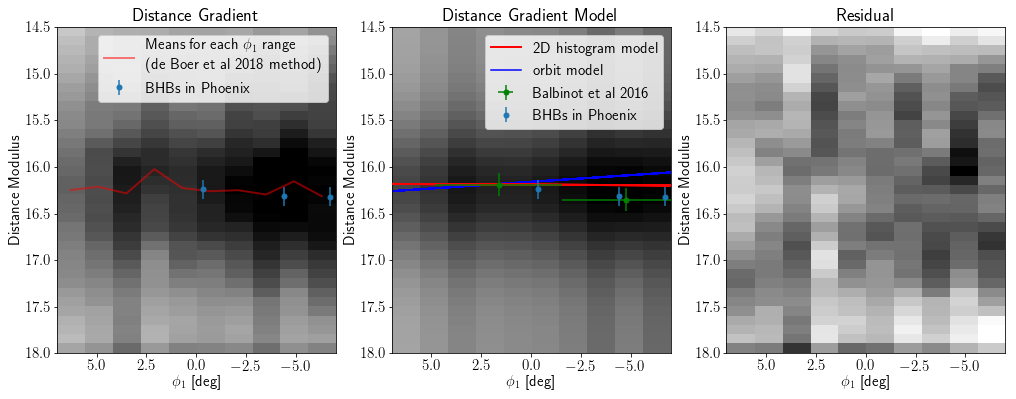

In [53]:
from sklearn.preprocessing import normalize

gradient_model = np.zeros((35,10))

gradient_model3 = np.copy(gradient_model)

grad3 = np.mean(samples[:,0])*bin_centers+np.mean(samples[:,1])
print(np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:,2]))
stddev = np.mean(samples[:,2])

lin_int = int1d_map[80]
int_corr = np.zeros(len(bin_centers))

for i in range(len(bin_centers)):    
    int_corr[i] = np.max(histmap[:,i])

int_corr = int_corr / np.max(int_corr)


background = np.concatenate((histmap[:10], histmap[-10:]))
backg = np.apply_along_axis(np.mean, axis=0, arr = background)
print(backg)

peak_ave = np.max(norm_histmap[15:20])

for i in range(len(grad3)):
    gradient_model3[:,i] = norm.pdf(x_interval_for_fit, grad3[i], stddev)
    gradient_model3[:,i] = gradient_model3[:,i] * int_corr[i]
gradient_model33 = gradient_model3*(peak_ave-backg) + backg


ys1 = -0.02*phi1+16.27
ys2 = np.mean(samples[:,0])*phi1+np.mean(samples[:,1])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,6))
ax1.pcolormesh(xx,yy,norm_histmap, vmin = 300, vmax=2000, rasterized = True)
ax1.set_xlim(7, -7)
ax1.set_ylim(18, 14.5)
ax1.plot(bin_centers, allmeans, linewidth = 2, c = 'r', alpha=0.5, 
         label='Means for each $\phi_1$ range \n (de Boer et al 2018 method)')
ax1.errorbar(brb_phi1, brb_dm, yerr = 0.1, linestyle='none', marker='o', markersize=5, label='BHBs in Phoenix')
ax1.set_xlabel(r'$\phi_1$ [deg]')
ax1.set_ylabel(r'Distance Modulus')
ax1.set_title(r'Distance Gradient')
ax1.legend()

ax2.pcolormesh(xx,yy,gradient_model33, vmin = 300, vmax = 2000, rasterized = True, zorder=1)
ax2.set_xlim(7, -7)
ax2.set_ylim(18, 14.5)
#ax2.plot(phi1, ys1, linewidth = 2, c = 'g', alpha = 0.5, label=r'Balbinot et al 2016')
ax2.plot(phi1, ys2, linewidth = 2, c = 'r', label=r'2D histogram model', zorder=3)
ax2.plot(orbit_phi1, orbit_dist_pred, c = 'b', label = 'orbit model', zorder=2)
#ax2.plot([7.5, -7.5], [16.19, 16.19], linewidth = 2, c = 'g', label=r'Balbinot et al 2016', 
        # linestyle='dashed')
ax2.errorbar([1.63, -4.75], [16.19, 16.35], yerr = 0.12, xerr=3.2, linestyle='none', marker='o', markersize=5, c='g', 
             label='Balbinot et al 2016', zorder=4)
#ax2.fill_between([-7.5, 7.5], [16.07, 16.07], [16.31, 16.31], color='g', alpha=0.2)
ax2.errorbar(brb_phi1, brb_dm, yerr = 0.1, linestyle='none', marker='o', markersize=5, 
             label='BHBs in Phoenix', zorder=5)
#ax2.errorbar([-5,5], [16.35, 16.19], yerr = 0.12, linestyle='none', marker='o', markersize=5, c='g', fmt='none')
ax2.set_xlabel(r'$\phi_1$ [deg]')
ax2.set_ylabel(r'Distance Modulus')
ax2.set_title(r'Distance Gradient Model')
ax2.legend()

ax3.pcolormesh(xx,yy,norm_histmap - gradient_model33, vmin=-300, vmax=300, rasterized = True)
ax3.set_xlim(7, -7)
ax3.set_ylim(18, 14.5)
ax3.set_xlabel(r'$\phi_1$ [deg]')
ax3.set_ylabel(r'Distance Modulus')
ax3.set_title(r'Residual')
#ax3.legend()
plt.savefig('phoenix_distance_gradient.pdf')
plt.show()

In [45]:
balb_phi1, balb_phi2,balb_R=streamlib.rotation(phoenix_ends,
                                            np.array([25.25, 21.75]),
                                            np.array([-47.5, -53.5]))
print(balb_phi1)

[ 1.63990469 -4.75361555]


In [46]:
print(samples.shape)

(120000, 3)


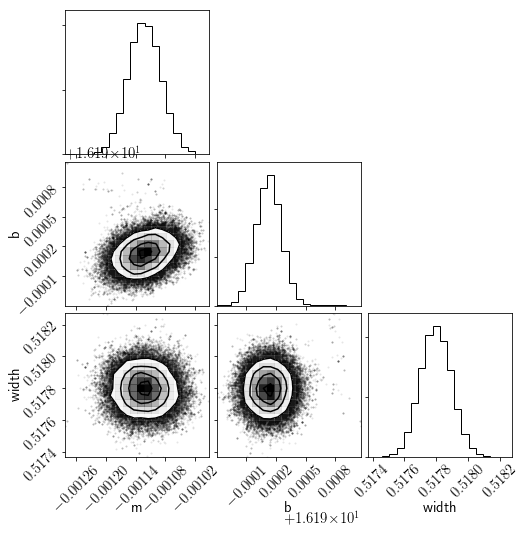

In [47]:
import corner

fig = corner.corner(samples, labels = ["m", "b", "width"])

Above plot is width corrected.

What we can say from this plot is that distance gradient is hard to measure in this way since both phoenix dwarf and possible intruder are at the extremes making the length of reliable distance modulus measurements about 10 deg. What we can conclude is that the distance gradient if there is one is close to 0 and all of Phoenix is at about the same distance away from us. The orbit model reinforces this but does give a slight gradient as well.

In [48]:
# 2d distance gradient model simulation
sim_grad = -0.0
sim_width = 0.5


sim_phi1 = np.random.uniform(-7,7, size = 1000000)
sim_phi1_bins = np.linspace(-7,7,11)
sim_bin_centers = sim_phi1_bins[:-1]+0.5*(sim_phi1_bins[1] - sim_phi1_bins[0])
sim_dist = np.copy(sim_phi1)
sim_dist[:] = np.random.normal(16.3+sim_grad*sim_phi1[:], sim_width)
print(len(sim_dist))

#sim_dist = []
#for i in range(len(sim_phi1)):
#    sim_dist = np.append(sim_dist, np.random.normal(16.3+sim_grad*sim_phi1[i], 0.5))

1000000


1000000


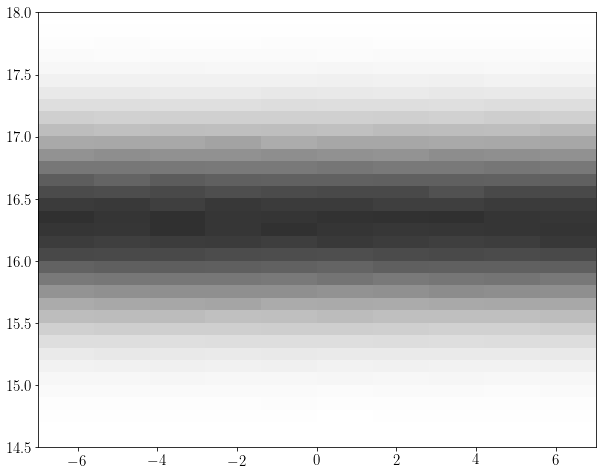

In [49]:
print(len(sim_dist))
sim_v = plt.hist2d(sim_phi1, sim_dist, bins=(10, 35), range=([-7,7], [14.5, 18]), vmax=10000)
sim_histmap = np.transpose(np.array(sim_v[0]))

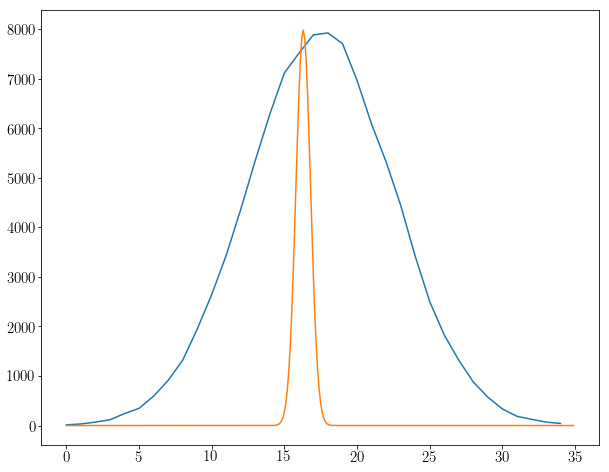

In [50]:
import scipy
plt.plot(sim_histmap[:,1])
x_values = np. arange(0, 35, 0.1)
y_values = scipy.stats.norm(16.3, 0.5)
print(y_values)
plt.plot(x_values, 10000*y_values.pdf(x_values))

In [51]:
import emcee
import warnings; warnings.simplefilter('ignore')
ndim, nwalkers = 3, int(12)
p01 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
p01[:, 0] = p01[:, 0]*.4 - 0.2  # slope: (-0.2, 0.2) # might want to log space?
p01[:, 1] = p01[:, 1]*0.5 + 16  # distance_modulus: (16.0, 16.5)
p01[:, 2] = p01[:, 2]*0.4 + 0.25  # gaussian width: [0.25, 0.65]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[sim_histmap])

print(p01)
# burn-in
pos1, prob1, state1 = sampler.run_mcmc(p01, 100)
sampler.reset()

pos1, prob1, state1 = sampler.run_mcmc(pos1, 1000)

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

[[-1.72502583e-01  1.64551318e+01  4.18792947e-01]
 [ 1.12364354e-02  1.63291416e+01  2.57422828e-01]
 [-1.93438755e-01  1.64919630e+01  6.38056019e-01]
 [ 7.32626464e-02  1.60349334e+01  3.29957179e-01]
 [-1.13997109e-01  1.63586731e+01  4.78085978e-01]
 [-1.50375195e-01  1.61635738e+01  3.14256954e-01]
 [-1.56009670e-01  1.61275166e+01  4.32337646e-01]
 [ 8.44798250e-02  1.60739034e+01  5.95771671e-01]
 [ 1.34168345e-01  1.62782279e+01  2.72636807e-01]
 [ 1.95907017e-02  1.63246942e+01  6.49055782e-01]
 [ 7.41587968e-02  1.64971049e+01  3.40345279e-01]
 [ 1.54205792e-01  1.60732268e+01  2.94789042e-01]]
emcee: Exception while calling your likelihood function:
  params: [-2.51531165e-04  1.62478877e+01  2.03019815e-01]
  args: [array([[2.100e+01, 1.400e+01, 1.900e+01, 2.000e+01, 1.500e+01, 1.600e+01,
        2.000e+01, 2.000e+01, 9.000e+00, 8.000e+00],
       [3.300e+01, 3.200e+01, 2.000e+01, 4.300e+01, 4.200e+01, 3.500e+01,
        2.700e+01, 3.200e+01, 3.500e+01, 3.000e+01],
       

Traceback (most recent call last):
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-36-8c457ed83530>", line 42, in log_probability
    return lp + log_likelihood(model_parameters, norm_histmap)
  File "<ipython-input-36-8c457ed83530>", line 26, in log_likelihood
    grad_model[:,i] = norm.pdf(x_interval_for_fit, slope*bin_centers[i]+yint, width)
  File "/home/s1/tavangar/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py", line 1658, in pdf
    args, loc, scale = self._parse_args(*args, **kwds)
  File "<string>", line 2, in _parse_args
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:, i], 100, color="k", histtype="step")
    print(np.min(sampler.flatchain[:, i]))
    plt.title("Dimension {0:d}".format(i))
    #plt.savefig('likelihood_sgr_%i.png' % i)
    plt.show()

samples = sampler.chain.reshape(-1, ndim)
print(np.mean(sampler.flatchain[:, 0]), np.std(sampler.flatchain[:, 0]))
print(np.mean(sampler.flatchain[:, 1]), np.std(sampler.flatchain[:, 1]))
print(np.mean(sampler.flatchain[:, 2]), np.std(sampler.flatchain[:, 2]))

In [ ]:
from sklearn.preprocessing import normalize

gradient_model = np.zeros((35,10))

gradient_model3 = np.copy(gradient_model)

#grad3 = np.mean(samples[:,0])*bin_centers+np.mean(samples[:,1])
#print(np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:,2]))
#stddev = np.mean(samples[:,2])
grad3 = 0*sim_bin_centers+16.3
print(np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:,2]))
stddev = 0.5

int_corr = np.zeros(len(sim_bin_centers))

for i in range(len(sim_bin_centers)):    
    int_corr[i] = np.max(sim_histmap[:,i])

#int_corr = int_corr / np.max(int_corr)

background = np.concatenate((sim_histmap[:10], sim_histmap[-10:]))
backg = np.apply_along_axis(np.mean, axis=0, arr = background)
backg = 0
print(backg)

peak_ave = np.max(sim_histmap[15:20])

for i in range(len(grad3)):
    gradient_model3[:,i] = norm.pdf(x_interval_for_fit, grad3[i], stddev)
    #gradient_model3[:,i] = gradient_model3[:,i] * int_corr[i]
gradient_model33 = gradient_model3*peak_ave


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,6))
ax1.pcolormesh(xx,yy,sim_histmap, vmax=10000, rasterized = True)
ax1.set_xlim(7, -7)
ax1.set_ylim(18, 14.5)
ax1.set_xlabel(r'Phi 1')
ax1.set_ylabel(r'Distance Modulus')
ax1.set_title(r'Distance Gradient')
ax1.legend()

ax2.pcolormesh(xx,yy,gradient_model33, vmax = 10000, rasterized = True)
ax2.set_xlim(7, -7)
ax2.set_ylim(18, 14.5)
ax2.set_xlabel(r'Phi 1')
ax2.set_ylabel(r'Distance Modulus')
ax2.set_title(r'Distance Gradient Model')
ax2.legend()

ax3.pcolormesh(xx,yy,sim_histmap - gradient_model33, vmin = -300, vmax = 300, rasterized = True)
ax3.set_xlim(7, -7)
ax3.set_ylim(18, 14.5)
ax3.set_xlabel(r'Phi 1')
ax3.set_ylabel(r'Distance Modulus')
ax3.set_title(r'Residual')
ax3.legend()

plt.show()

## Compare Density Variations of Various Streams

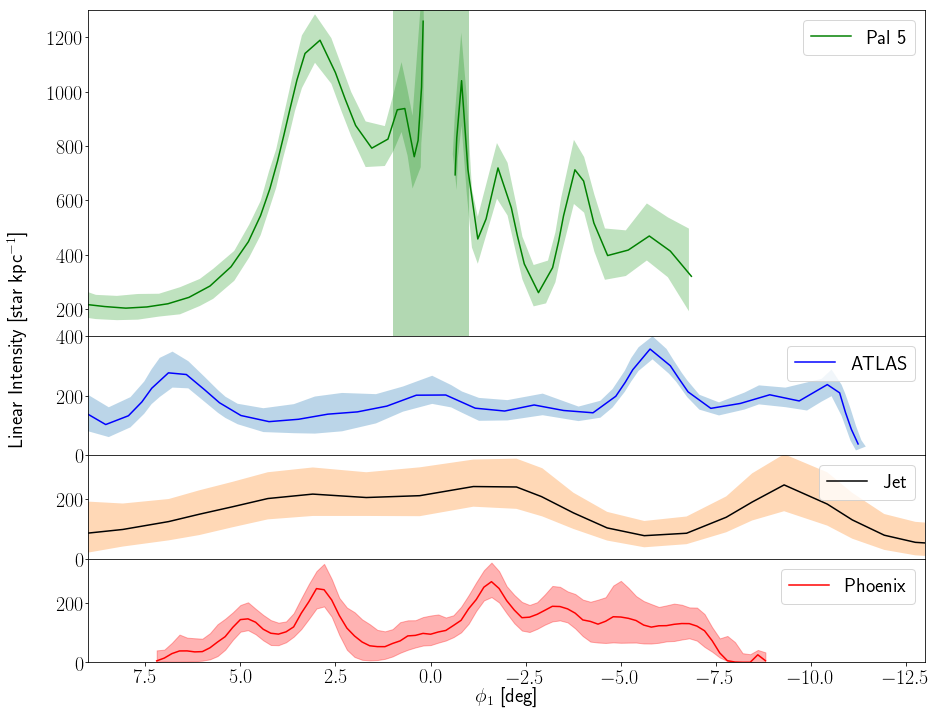

In [10]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

atlas_dens = pd.read_csv('stream_papers_density_plots/ATLAS_linear.csv')
pal5_dens = pd.read_csv('stream_papers_density_plots/Pal5_linear.csv')
jet_dens = pd.read_csv('stream_papers_density_plots/jet_linear.csv')

atlas_high_dens = pd.read_csv('stream_papers_density_plots/ATLAS_linear_high.csv').values
pal5_high_dens = pd.read_csv('stream_papers_density_plots/Pal5_linear_high.csv').values
jet_high_dens = pd.read_csv('stream_papers_density_plots/jet_linear_high.csv').values

atlas_low_dens = pd.read_csv('stream_papers_density_plots/ATLAS_linear_low.csv').values
pal5_low_dens = pd.read_csv('stream_papers_density_plots/Pal5_linear_low.csv').values
jet_low_dens = pd.read_csv('stream_papers_density_plots/jet_linear_low.csv').values
pal5_low_dens = pal5_low_dens[pal5_low_dens[:,0].argsort()]
pal5_high_dens = pal5_high_dens[pal5_high_dens[:,0].argsort()]

rect = plt.Rectangle((-1,100), width = 2, height = 1200, facecolor = 'g', alpha=0.3)

#taking out +/- 1 around progenitor of pal5
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,12), gridspec_kw={'height_ratios': [11, 4, 3.5, 3.5]}, sharex=True)
fig.text(0.05, 0.5, r'Linear Intensity [star kpc$^{-1}$]', va='center', rotation='vertical')

line1, = ax2.plot(atlas_dens['phi1'], atlas_dens['density']/0.4, label=r'ATLAS', c = 'b')
vertices_atlas = np.zeros((len(atlas_low_dens[:,0])+len(atlas_high_dens[:,0]), 2))
vertices_atlas[:,0] = np.append(atlas_low_dens[:,0], np.flip(atlas_high_dens[:,0], 0))
vertices_atlas[:,1] = np.append(atlas_low_dens[:,1]/0.4, np.flip(atlas_high_dens[:,1]/0.4, 0))
path_atlas = Path(vertices_atlas)
patch_atlas = PathPatch(path_atlas, facecolor='C0', edgecolor='none', alpha=0.3)
ax2.add_patch(patch_atlas)

line2, = ax1.plot(pal5_dens['phi1'][:22], pal5_dens['density'][:22]*60/0.41, c='g', label=r'Pal 5')
line20, = ax1.plot(pal5_dens['phi1'][23:], pal5_dens['density'][23:]*60/0.41, c='g', label='_nolegend_')
vertices_pal5_0 = np.zeros((len(pal5_low_dens[:22,0])+len(pal5_high_dens[:22,0]), 2))
vertices_pal5_0[:,0] = np.append(pal5_low_dens[:22,0], np.flip(pal5_high_dens[:22,0], 0))
vertices_pal5_0[:,1] = np.append(pal5_low_dens[:22,1]*60/0.41, np.flip(pal5_high_dens[:22,1]*60/0.41, 0))
path_pal5_0 = Path(vertices_pal5_0)
patch_pal5_0 = PathPatch(path_pal5_0, facecolor='C2', edgecolor='none', alpha=0.3)
ax1.add_patch(patch_pal5_0)

vertices_pal5_1 = np.zeros((len(pal5_low_dens[24:,0])+len(pal5_high_dens[24:,0]), 2))
vertices_pal5_1[:,0] = np.append(pal5_low_dens[24:,0], np.flip(pal5_high_dens[24:,0], 0))
vertices_pal5_1[:,1] = np.append(pal5_low_dens[24:,1]*60/0.41, np.flip(pal5_high_dens[24:,1]*60/0.41, 0))
path_pal5_1 = Path(vertices_pal5_1)
patch_pal5_1 = PathPatch(path_pal5_1, facecolor='C2', edgecolor='none', alpha=0.3)
ax1.add_patch(patch_pal5_1)


line3, = ax3.plot(jet_dens['phi1'], jet_dens['density']/0.5, c='k', label=r'Jet')
vertices_jet = np.zeros((len(jet_low_dens[:,0])+len(jet_high_dens[:,0]), 2))
vertices_jet[:,0] = np.append(jet_low_dens[:,0], np.flip(jet_high_dens[:,0], 0))
vertices_jet[:,1] = np.append(jet_low_dens[:,1]/0.5, np.flip(jet_high_dens[:,1]/0.5, 0))
path_jet = Path(vertices_jet)
patch_jet = PathPatch(path_jet, facecolor='C1', edgecolor='none', alpha=0.3)
ax3.add_patch(patch_jet)

line4, = ax4.plot(pp1[80], int1d_map[80] /0.3, c = 'r', label=r'Phoenix')
ax4.fill_between(pp1[80], int1d_lo_map[80]/0.3, int1d_hi_map[80]/0.3, alpha = 0.3, color= 'r')
ax1.add_patch(rect)
ax1.set_ylim(100,1300)
ax2.set_ylim(0,400)
ax3.set_ylim(0,350)
ax4.set_ylim(0,350)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')


plt.xlabel(r'$\phi_1$ [deg]')
plt.xlim(9,-13)


#ax1.tick_params(
#    axis='y',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    left=False,      # ticks along the bottom edge are off
#    right=False,         # ticks along the top edge are off
#    labelleft=False) # labels along the bottom edge are off
plt.subplots_adjust(wspace=0, hspace=0)

#line_1, = ax2.plot(atlas_dens['phi1'], atlas_dens['density']/0.4, label=r'ATLAS', c = 'b')
#line_2, = ax2.plot(pal5_dens['phi1'][:22], pal5_dens['density'][:22]*60/0.41, c='g', label=r'Pal 5')
#line_20, = ax2.plot(pal5_dens['phi1'][23:], pal5_dens['density'][23:]*60/0.41, c='g', label='_nolegend_')
#line_3, = ax2.plot(jet_dens['phi1'], jet_dens['density']/0.5, c='k', label=r'Jet')
#line4, = ax2.plot(pp1[80], int1d_map[80]/0.3, c = 'r', label=r'Phoenix')
#ax2.set_ylim(0,1300)
#ax2.set_xlim(9,-13)
#ax2.set_ylabel(r'Linear Intensity [star/kpc]')
#ax2.set_xlabel(r'$\phi_1$ [deg]')
#ax2.legend()
plt.savefig('density_comparisons.pdf', bbox_inches = 'tight')
plt.show()

## Questions / Next Steps

Create distance gradient model with various slopes and widths and compare to actual image for different slopes. Calculate likelihood.

Start reading and writing.

Check to see if uptick at low phi1 could potentially be caused by tuc III extension. End of phoenix is about 20 degrees from middle of Tuc III and with distance gradient of -0.14 (Erkal et al 2018), combined with distance modulus of 17 at about phi1_tucIII = 0, could potentially lead to distance modulus of around 14.5 at phi1_phoenix = -9. Too low to account for the uptick unless something else happens

Seems to not be Tuc III extension but whatever it is, it could account for the uptick since it seems to have a distance modulus of around 16.2

Even possible that clump at -9 is not as associated with phoenix as it is with whatever is the other feature

In [32]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(5,5), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': True})
    
def run(hpxmap, coords, sigma=0.25,**kwargs):
    defaults = dict(cmap='gray_r')
    setdefaults(kwargs, defaults)

    pixscale = 0.1 # deg/pix
    xmin, xmax = coords[0], coords[1]
    ymin, ymax = coords[2], coords[3]
    nxpix = int((xmax-xmin)/pixscale) + 1
    nypix = int((ymax-ymin)/pixscale) + 1
    x = np.linspace(xmin,xmax,nxpix)
    y = np.linspace(ymin,ymax,nypix)
    XY = np.meshgrid(x,y)
    xx,yy = np.meshgrid(x,y)
    
    nside = hp.get_nside(hpxmap)
    pix = hp.ang2pix(nside,xx.flat,yy.flat,lonlat=True)

    val = hpxmap[pix]
    vv = val.reshape(xx.shape)

    # Smoothed data
    smooth = nd.gaussian_filter(vv, sigma=sigma/pixscale)
    smooth1=np.copy(smooth)
    smooth = smooth.reshape(val.shape)
    smooth1 = smooth1.reshape(val.shape)
    mask = np.load('des/des_mask_no_sgr.npy')
    m = mask[pix]
    smooth[m==1] = np.nan
    smooth = smooth.reshape(xx.shape)
    smooth1[m==1] = np.median(val) + 0.5
    smooth1 = smooth1.reshape(xx.shape)

    deg = 5
    
    fit_params, fit_errors = polyfit2d.curvefit2d(deg, XY, np.ravel(smooth1))
    
    bkg = polynomial.polyval2d(xx, yy, fit_params)

    plt.figure(figsize=(6,6))
    plt.title(r'data - bkg')
    plt.set_cmap('gray_r')
    kwargs.update(vmin=-1.5,vmax=1.5)
    #kwargs.update(vmin=0,vmax=12)
    #draw_image(xx,yy,smooth,**kwargs)

    region_plot.draw_image(xx,yy,smooth-bkg,**kwargs)
    res = smooth-bkg
    return xx,yy,res

def plot_iso(iso, ax, c):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    ax.scatter(iso.data['g']-iso.data['r'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=1)
    #plt.gca().invert_yaxis()
    ax.set_xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)
    
    
def intersect1d(ar1, ar2, assume_unique=False, return_indices=False):
    """
    Find the intersection of two arrays.
    Return the sorted, unique values that are in both of the input arrays.
    Parameters
    ----------
    ar1, ar2 : array_like
        Input arrays. Will be flattened if not already 1D.
    assume_unique : bool
        If True, the input arrays are both assumed to be unique, which
        can speed up the calculation.  Default is False.
    return_indices : bool
        If True, the indices which correspond to the intersection of the two
        arrays are returned. The first instance of a value is used if there are
        multiple. Default is False.
        .. versionadded:: 1.15.0
    Returns
    -------
    intersect1d : ndarray
        Sorted 1D array of common and unique elements.
    comm1 : ndarray
        The indices of the first occurrences of the common values in `ar1`.
        Only provided if `return_indices` is True.
    comm2 : ndarray
        The indices of the first occurrences of the common values in `ar2`.
        Only provided if `return_indices` is True.
    See Also
    --------
    numpy.lib.arraysetops : Module with a number of other functions for
                            performing set operations on arrays.
    Examples
    --------
    >>> np.intersect1d([1, 3, 4, 3], [3, 1, 2, 1])
    array([1, 3])
    To intersect more than two arrays, use functools.reduce:
    >>> from functools import reduce
    >>> reduce(np.intersect1d, ([1, 3, 4, 3], [3, 1, 2, 1], [6, 3, 4, 2]))
    array([3])
    To return the indices of the values common to the input arrays
    along with the intersected values:
    >>> x = np.array([1, 1, 2, 3, 4])
    >>> y = np.array([2, 1, 4, 6])
    >>> xy, x_ind, y_ind = np.intersect1d(x, y, return_indices=True)
    >>> x_ind, y_ind
    (array([0, 2, 4]), array([1, 0, 2]))
    >>> xy, x[x_ind], y[y_ind]
    (array([1, 2, 4]), array([1, 2, 4]), array([1, 2, 4]))
    """
    ar1 = np.asanyarray(ar1)
    ar2 = np.asanyarray(ar2)

    if not assume_unique:
        if return_indices:
            ar1, ind1 = np.unique(ar1, return_index=True)
            ar2, ind2 = np.unique(ar2, return_index=True)
        else:
            ar1 = np.unique(ar1)
            ar2 = np.unique(ar2)
    else:
        ar1 = ar1.ravel()
        ar2 = ar2.ravel()

    aux = np.concatenate((ar1, ar2))
    if return_indices:
        aux_sort_indices = np.argsort(aux, kind='mergesort')
        aux = aux[aux_sort_indices]
    else:
        aux.sort()

    mask = aux[1:] == aux[:-1]
    int1d = aux[:-1][mask]

    if return_indices:
        ar1_indices = aux_sort_indices[:-1][mask]
        ar2_indices = aux_sort_indices[1:][mask] - ar1.size
        if not assume_unique:
            ar1_indices = ind1[ar1_indices]
            ar2_indices = ind2[ar2_indices]

        return int1d, ar1_indices, ar2_indices
    else:
        return int1d
    
plot_pretty(fontsize=15)

print('Loading healpix cubes ...')
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz')

Loading healpix cubes ...
Reading /data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz...
Skipping fracdet...


## Making Phoenix Movie

In [ ]:
# Create movie
reload(region_plot)
from PIL import Image
images = []
for i in range(150,200, 2):
    print(i/10.)
    d = region_plot.prepare_hpxmap(i/10., hpxcube, fracdet, modulus)
    xx1,yy1,res1 = region_plot.run_phoenix(d, dust=sfd, planck=planck, sigma = 0.2)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.pcolormesh(xx1,yy1,res1, vmin = -1.5, vmax = 1.5, cmap = 'gray_r')
    ax.set_title(r'$m-M = {}$'.format(i/10.), fontsize=30)
    ax.set_xlim(45,5)
    ax.set_aspect('equal')
    plt.grid('on',ls = ':',color='gray')
    plt.savefig('/data/des81.b/data/tavangar/streams/des/phoenix_mov/{}_phoenix.jpg'.format(str(i)), dpi=50)

## Southwest Structure/Stream

In [ ]:
southwest_ends = [12.7, -56.6, 20.5, -55.4]


reload(region_plot)
d = region_plot.prepare_hpxmap(16.2, hpxcube, fracdet, modulus) 
pp1_sw, pp2_sw, vv_sw, smooth_res_sw, smooth_sw, vv_mask_sw = region_plot.stream_coord_spatial(d, southwest_ends, full_data, 
                                                                      deg =5, sigma=0.25, stream = 'Phoenix')
plt.xlim(5, -5)
plt.ylim(-2,2)

In [ ]:
data = np.copy(full_data)
phi1_sw, phi2_sw,R_sw = streamlib.rotation(southwest_ends, data['RA'], data['DEC'])

iso = isochrone.factory(name='Dotter2008',
                        age=13.0,  # Gyr
                        metallicity=0.0004, # Z
                        distance_modulus=16.2
                       )

In [ ]:
reload(plot_hess)


iso = isochrone.factory(name='Dotter2008',
                        age=13.5,  # Gyr
                        metallicity=0.0007, # Z
                        distance_modulus=16.3
                       )

stream_width = 0.4
bkg_start = 1.25
stream_hess(full_data, phi1_sw, phi2_sw, -5, 5, stream_width, bkg_start)

In [ ]:
import ugali
from ugali import isochrone

angsep = ugali.utils.projector.angsep(19.1, -56.5, data['RA'], data['DEC'])
d = np.where(angsep < 0.3)
sw_cluster = data[d]

In [ ]:
iso = isochrone.factory(name='Dotter2008',
                        age=13.0,  # Gyr
                        metallicity=0.0004, # Z
                        distance_modulus=16.4
                       )

fig, (ax1) = plt.subplots(1,1, figsize=(6,5))
ax1, im1 = plot_hess.plot_hess(sw_cluster, ax=ax1, dx=0.15 / 5., dy=0.75 / 6.)
plot_iso(iso, 'r')
#plt.plot(mk[:,0], mk[:,1]+mu, c='k')
fig.colorbar(im1, ax = ax1)
plt.xlim(0,1)
plt.ylim(24, 16)


# Other Stuff

In [ ]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(18, hpxcube, fracdet, modulus)
xx,yy,smooth = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.25)
#plt.scatter(19.1, -56.5, s = 10, c='r')
#plt.scatter(27.2, -44.1, s = 10, c='r')
#plt.scatter(28.3, -44.8, s = 10, c='r')
plt.title(r'$m-M = 18.0$', fontsize=25)
plt.xlabel(r'RA', fontsize=25)
plt.ylabel(r'Dec', fontsize=25)
#plt.xlim(0,1)
#plt.ylim(24, 16)
plt.show()

In [ ]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(16.5, hpxcube, fracdet, modulus)
xx,yy,smooth = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.25)
#plt.scatter(19.1, -56.5, s = 10, c='r')
#plt.scatter(27.2, -44.1, s = 10, c='r')
#plt.scatter(28.3, -44.8, s = 10, c='r')
plt.title(r'$m-M = 18.0$', fontsize=25)
plt.xlabel(r'RA', fontsize=25)
plt.ylabel(r'Dec', fontsize=25)
plt.xlim(0,-30)
plt.ylim(-2,2)
plt.show()

In [ ]:
filename2='/home/s1/nshipp/projects/stream_search/data/DECaLS_iso_hpxcube_z0.0004_a13.0_gmax23.fits.gz'
hpxcube2, fracdet2, modulus2 = region_plot.load_hpxcube(filename2)

In [ ]:
reload(region_plot)
gdr2 = fits.read('gdr2_orphan_sergey.fits')
ra_gdr2, dec_gdr2 = gdr2['ra'], gdr2['dec']
ra_gdr2[np.where(ra_gdr2 > 180)] = ra_gdr2[np.where(ra_gdr2 > 180)] - 360


decals_bhb = fits.read('decals_bhb.fits')
decals_bhb = decals_bhb[np.where(decals_bhb['pbhb'] > 0.05)]
bhb_ra, bhb_dec = decals_bhb['ra'], decals_bhb['dec']
bhb_ra[np.where(bhb_ra > 180)] = bhb_ra[np.where(bhb_ra > 180)] - 360

smap=skymap_factory('pal13')
lon1,lat1 = smap().draw_great_circle(-40.7,-59.9, -28.3, -43, 'full')

%matplotlib inline
d = region_plot.prepare_hpxmap(16.5, hpxcube2, fracdet2, modulus2)
xx,yy,smooth = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.15)
plt.figure(figsize=(8,8))
plt.title(r'$m-M = 18.0$', fontsize=25)
plt.scatter(ra_gdr2, dec_gdr2)
plt.plot(lon1,lat1, c='b', linewidth=1.5, linestyle='dashed')
plt.scatter(bhb_ra, bhb_dec, c='r', s = 0.3)
plt.xlabel(r'RA', fontsize=25)
plt.ylabel(r'Dec', fontsize=25)
plt.xlim(50,-50)
plt.ylim(-80, 20)
plt.show()

In [ ]:
decals_bhb = fits.read('decals_bhb.fits')
decals_bhb = decals_bhb[np.where(decals_bhb['pbhb'] > 0.05)]
decals_bhb = decals_bhb[np.where(np.abs(decals_bhb['dec']) < 20)]
decals_bhb = decals_bhb[np.where(decals_bhb['ra'] > 330)]
print(len(decals_bhb))
plt.scatter(decals_bhb['flux_g']-decals_bhb['flux_r'], decals_bhb['flux_z'], s = 5)
iso = isochrone.factory(name='Dotter2008',
                        age=13.0,  # Gyr
                        metallicity=0.0004, # Z
                        distance_modulus=18.2)
plot_iso(iso, 'b')
plt.xlim(-0.5,2)
plt.ylim(25, 0)

In [ ]:
decals_bhb = fits.read('decals_bhb.fits')
print(len(decals_bhb))
decals_bhb['ra'][np.where(decals_bhb['ra'] > 180)] = decals_bhb['ra'][np.where(decals_bhb['ra'] > 180)] - 360
decals_bhb = decals_bhb[np.where(decals_bhb['pbhb'] > 0.05)]
print(len(decals_bhb))
decals_bhb = decals_bhb[np.where(np.abs(decals_bhb['dec']) < 20)]
decals_bhb = decals_bhb[np.where((decals_bhb['ra'] < 0) & (decals_bhb['ra'] > -30))]
print(len(decals_bhb))
#decals_bhb = decals_bhb[np.where((decals_bhb['flux_g'] - decals_bhb['flux_r'] > -0.4) & 
#                        (decals_bhb['flux_g'] - decals_bhb['flux_r'] < 0))]
bhb_g, bhb_r = decals_bhb['flux_g'], decals_bhb['flux_r']
M_g = 0.398 - 0.392*(bhb_g-bhb_r) + 2.729*(bhb_g-bhb_r)**2 + 29.118*(bhb_g-bhb_r)**3
print(len(decals_bhb[np.where(bhb_g - M_g > 14)]))
plt.hist(bhb_g - M_g, bins = 30, range=[15,22])
plt.figure()
plt.scatter(bhb_g-bhb_r, bhb_g - M_g, s = 2)
plt.xlim(-0.75,1)
plt.ylim(25, 10)
mydata = np.round((bhb_g) * 2 ) / 2



dist17 = decals_bhb[mydata == 17]
dist175 = decals_bhb[mydata == 17.5]
dist18 = decals_bhb[mydata == 18]
dist185 = decals_bhb[mydata == 18.5]
dist19 = decals_bhb[mydata == 19]
dist195 = decals_bhb[mydata == 19.5]
dist20 = decals_bhb[mydata == 20]
dist205 = decals_bhb[mydata == 20.5]
dist21 = decals_bhb[mydata == 21]
dist215 = decals_bhb[mydata == 21.5]

plt.figure()
plt.scatter(dist155['ra'], dist155['dec'], c='orange')
plt.scatter(dist16['ra'], dist16['dec'], c='y')
plt.scatter(dist165['ra'], dist165['dec'], c='b')
plt.scatter(dist17['ra'], dist17['dec'], c='r')
plt.scatter(dist175['ra'], dist175['dec'], c='g')
plt.scatter(dist18['ra'], dist18['dec'], c='k')
plt.scatter(dist185['ra'], dist185['dec'], c='brown')
plt.scatter(dist19['ra'], dist19['dec'], c='purple')
plt.scatter(dist195['ra'], dist195['dec'], c='pink')
#plt.xlim(0, -30)
#plt.ylim(-17, 30)

In [ ]:


plt.hist2d(dist17['ra'], dist17['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 17')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist175['ra'], dist175['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 17.5')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist18['ra'], dist18['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 18')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist185['ra'], dist185['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 18.5')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist19['ra'], dist19['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 19')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist195['ra'], dist195['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 19.5')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist20['ra'], dist20['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 20')
plt.xlim(0,-30)
plt.show()

plt.hist2d(dist205['ra'], dist205['dec'], bins=(15,15), range=([-30,0], [-20, 30]))
plt.title(r'm-M = 20.5')
plt.xlim(0,-30)
plt.show()

In [ ]:
reload(region_plot)
from PIL import Image
from matplotlib.patches import Ellipse
images = []
from streamlib import skymap_factory
smap=skymap_factory('pal13')
lon1,lat1 = smap().draw_great_circle(-40.7,-59.9, -28.3, -43, 'full')

for i in range(160,200, 2):
    print(i/10.)
    d = region_plot.prepare_hpxmap(i/10., hpxcube2, fracdet2, modulus2)
    xx,yy,smooth = region_plot.run(d,dust=sfd, planck=planck, sigma = 0.25)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.pcolormesh(xx,yy,smooth, vmin = -1.5, vmax = 1.5, cmap = 'gray_r')
    ax.plot(lon1,lat1, c='b', linewidth=1.5, linestyle='dashed')
    ax.set_title(r'm-M = {}'.format(i/10.))
    ax.set_xlim(0,-30)
    ax.set_ylim(-15,20)
    ax.set_aspect('equal')
    plt.grid('on',ls = ':',color='gray')
    plt.savefig('/data/des81.b/data/tavangar/streams/decals/orphan/{}_orphan.jpg'.format(str(i)), dpi=100)

In [ ]:
decals_bhb
